# Continuous Forest Monitoring Using Cumulative Sums of Sentinel-1 Timeseries

This notebook attempts to monitor forest change from a Sentinel 1 time series using a cumulative sums based approach.
The major reference for this notebook are:
* [Monitoring loss of tropical forest cover from Sentinel-1 time-series: A CuSum-based approach](https://doi.org/10.1016/j.jag.2021.102532)
* [Kellndorfer, J. Using SAR data for Mapping Deforestation and Forest Degradation. In The SAR Handbook.
  Comprehensive Methodologies for Forest Monitoring and Biomass Estimation; ServirGlobal: Hunstville, AL, USA,
  2019; pp. 65–79. SAR Training Workshop for Forest Applications PART 4 - SAR Time Series Change Point Detection:
  Change Detection on the Time Series Data: Cumulative Sum Change Detection for the entire image pg. 143 - 151](https://gis1.servirglobal.net/TrainingMaterials/SAR/SARHB_FullRes.pdf)

## Code Section 

In [1]:
# Load the necessary packages
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb, plot_lulc

In [2]:
# Connect to the datacube.
dc = datacube.Datacube(app='Forest_Reserves_Time_Series_Analysis')

In [3]:
# Define the area of interest. Northen Tinderet Reserve, Kenya
lat = 0.02
lon = 35.425
buffer = 0.1

# Convert the lat, lon, buffer into a range.
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat - buffer, lat + buffer)


# View the area of interest on an interactive map.
display_map(lon_range, lat_range)

In [4]:
# The year 2019 is our base year/control sample. 
reference_year = "2019"

# We want to detect the forest changes that occurred from the beginning of 2020 onwards.
change_year = "2020"

# Create a reusable datacube query object for loading data.
query = {
    "y": lat_range,
    "x": lon_range,
    "output_crs": "EPSG:6933",
    "resolution" : (-20,20),
}

print(query)

{'y': (-0.08, 0.12000000000000001), 'x': (35.324999999999996, 35.525), 'output_crs': 'EPSG:6933', 'resolution': (-20, 20)}


In [5]:
# load the Sentinel 1 imagery for the area of interest.
ds_s1 = load_ard(dc=dc,
                 products=["s1_rtc"],
                 measurements=['vv', 'vh'],
                 time=(reference_year, change_year),
                 sat_orbit_state="descending",
                 group_by="solar_day",
                 dtype='native',
                 **query)


# Add a ratio band to the Sentinel 1 dataset.
ds_s1['vh_vv'] = ds_s1.vh/ds_s1.vv

# Convert the backscatter values from power scale to logarithmic decibel scale. 
ds_s1['vv'] = 10 * xr.ufuncs.log10(ds_s1['vv'])
ds_s1['vh'] = 10 * xr.ufuncs.log10(ds_s1['vh'])
ds_s1['vh_vv'] = 10 * xr.ufuncs.log10(ds_s1['vh_vv'])

print(ds_s1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 50 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (time: 50, y: 1277, x: 966)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-29T03:19:14.507328 ... 2020-12...
  * y            (y) float64 1.531e+04 1.529e+04 ... -1.019e+04 -1.021e+04
  * x            (x) float64 3.408e+06 3.408e+06 ... 3.428e+06 3.428e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 -10.37 -8.748 -8.116 ... -10.73 -12.39
    vh           (time, y, x) float32 -14.07 -14.12 -14.44 ... -16.79 -17.55
    vh_vv        (time, y, x) float32 -3.701 -5.374 -6.324 ... -6.06 -5.16
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


This paper mentions a speckle filtering step usign as using the bilateral filter made available in the python PyRAT Toolbox (Reigber et al., 2019) with a kernel window size of 7 × 7 but I don't know how to implement that yet.
Maybe a different multi-temporal speckle filter could work?

Below is a function that computes the cumulative sums algorithm combined with a bootstrap analysis. 

In [7]:
def cumulativesums(ds, n_bootstraps=1500):
    '''
    Function to perform the cumulative sums on a Sentinel-1 time series.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Sentinel-1 time series with VH and/or VV polarization bands. 
    n_bootstraps: int
        The number of bootstraps to use
        
    Return
    ------
    xarray.Dataset
    '''
    # Temporal mean: mean of the time-series over each pixel.
    temporal_mean = ds.mean(dim="time", keep_attrs=True)
    # Expand the time dimension of the temporal_mean to match the Sentinel 1 dataset, ds.
    temporal_mean_ts = temporal_mean.expand_dims(time=ds.time )
    # Calculate the residuals.
    residuals = ds - temporal_mean_ts
    # Calculate the cumulative sum of the residuals.
    S = residuals.cumsum(dim='time')
    # Determine the maximum value of the cumulative sum of the residuals. 
    S_max = S.max(dim="time")
    # Determine the minimum value of the cumulative sum of the residuals.
    S_min = S.min(dim="time")
    # Compute the amplitude of the cumulative sum of the residuals.
    S_diff = S_max - S_min
    
    band_list= [i for i in temporal_mean.data_vars]
    # Create an empty xarray Dataset to store the results of the bootstrapping.
    results = xr.zeros_like(temporal_mean).drop_vars(band_list)
    # Conduct a bootstrap analysis based on the amplitude S_diff to validate or invalidate the change.
    band_list= [i for i in temporal_mean.data_vars]
    for band in band_list:
        # Get the residuals data for the band as a numpy array.
        residuals_np = residuals[band].data
        # to keep track of the maxium amplitude of the bootstrapped sample:
        S_diff_random_max = np.zeros_like(S_diff[band].data)
        # to compute the  amplitude sums of the bootstrapped sample:
        S_diff_random_sum  = np.zeros_like(S_diff[band].data)
        # to keep track of the count of the bootstrapped sample
        n_S_diff_gt_S_diff_random = np.zeros_like(S_diff[band].data)
        print(f"Running Bootstrapping for {band.upper()} polarization for %4.1f iterations ..." % (n_bootstraps))
        for i in range(n_bootstraps):
            # Randomize the time steps of the residuals
            random_index = np.random.permutation(residuals_np.shape[0])
            R_random = residuals_np[random_index, :,:]
            S_random = np.cumsum(R_random, axis=0)
            S_random_max = np.max(S_random, axis=0)
            S_random_min = np.min(S_random, axis=0)
            S_diff_random = S_random_max - S_random_min
            S_diff_random_sum += S_diff_random
            S_diff_random_max[np.greater(S_diff_random, S_diff_random_max)]=\
            S_diff_random[np.greater(S_diff_random, S_diff_random_max)]
            n_S_diff_gt_S_diff_random[np.greater(S_diff[band].data, S_diff_random)] += 1
            if ((i+1)/n_bootstraps*100)%10 == 0:
                print("\r%4.1f percent completed ..." % ((i+1)/n_bootstraps*100), end='\r', flush=True)
        print(f"Bootstrapping for {band.upper()} polarization complete.      ")
        # Compute for all the pixels:
        # the confidence level,
        # the change point significance metric 
        # and the product of the confidence level and and change point sigificant metric.
        CL = n_S_diff_gt_S_diff_random/n_bootstraps
        CP_significance = 1.- (S_diff_random_sum/n_bootstraps)/S_diff[band].data 
        CL_CP_significance = CL * CP_significance
        data_vars = [f"{band}_CL", f"{band}_CP_significance",  f"{band}_CL_CP_significance"]
        results[data_vars[0]] = (['y', 'x'], CL)
        results[data_vars[1]] = (['y', 'x'], CP_significance)
        results[data_vars[2]] = (['y', 'x'], CL_CP_significance)
    
    return results

* The date of change in the vegetation over the pixel is assumed to happen at the date when the cumulative sum of the residuals reaches a maximum.
* There is no global threshold over the magnitude of the change.
* A threshold is computed individually over each pixel, as the mean value of the time series may change from one pixel to another.
* The bootstrap analysis is a mean to check the validity of the change detected through an indirect measure of the impact of the order sequence on the time series.
* The bootstrap consists in conducting CuSum on a randomly modified backscatter timeseries nbootstraps times and check if the gener­ ated amplitude of the residuals is greater than the original amplitude of the residuals. nbootstraps is the number of bootstraps.
* Firstly, the original backscatter time-series is randomly reorganized, thus modifying the temporal order. 
* Then, the CuSum method is applied to the newly reorganized series to compute Rsum_randj_i and Asum_randj_i (with i the index of the bootstrap). The next step is to compute the difference of amplitude between Asumj and Asum_randj_i.

In [9]:
%%time 
# This step takes approximately 17 min 22 seconds to run. 
results = cumulativesums(ds=ds_s1, n_bootstraps=1000)
results

Running Bootstrapping for VV polarization for 1000.0 iterations ...
Bootstrapping for VV polarization complete.      
Running Bootstrapping for VH polarization for 1000.0 iterations ...
Bootstrapping for VH polarization complete.      
Running Bootstrapping for VH_VV polarization for 1000.0 iterations ...
Bootstrapping for VH_VV polarization complete.      
CPU times: user 17min 24s, sys: 4min 20s, total: 21min 45s
Wall time: 21min 45s


<xarray.Dataset>
Dimensions:                   (y: 1277, x: 966)
Coordinates:
    spatial_ref               int32 6933
  * y                         (y) float64 1.531e+04 1.529e+04 ... -1.021e+04
  * x                         (x) float64 3.408e+06 3.408e+06 ... 3.428e+06
Data variables:
    vv_CL                     (y, x) float32 0.98 0.996 1.0 1.0 ... 1.0 1.0 1.0
    vv_CP_significance        (y, x) float32 0.3486 0.4306 ... 0.469 0.5169
    vv_CL_CP_significance     (y, x) float32 0.3416 0.4288 ... 0.469 0.5169
    vh_CL                     (y, x) float32 1.0 1.0 0.999 0.998 ... 1.0 1.0 1.0
    vh_CP_significance        (y, x) float32 0.4953 0.4627 ... 0.5289 0.5137
    vh_CL_CP_significance     (y, x) float32 0.4953 0.4627 ... 0.5289 0.5137
    vh_vv_CL                  (y, x) float32 0.969 0.952 0.903 ... 0.968 0.974
    vh_vv_CP_significance     (y, x) float32 0.3362 0.2922 ... 0.311 0.3362
    vh_vv_CL_CP_significance  (y, x) float32 0.3258 0.2782 ... 0.3011 0.3274
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

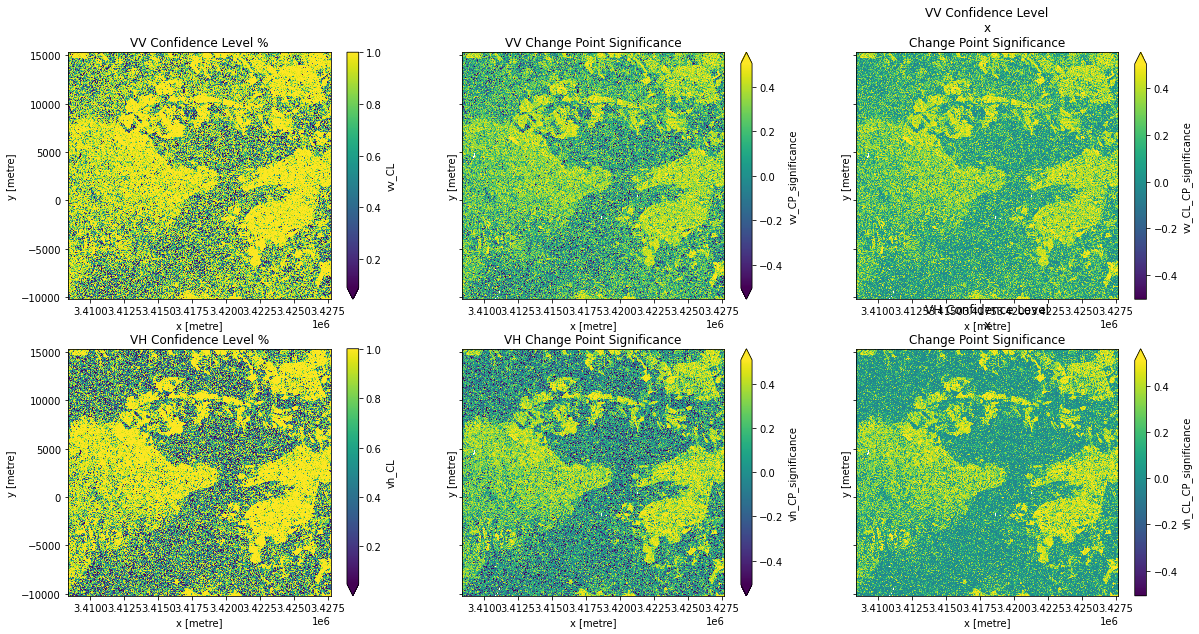

In [11]:
# PLot the confidence metrics. 
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)

results['vv_CL'].plot.imshow(cmap="viridis", robust=True, ax=ax[0,0])
results['vv_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[0,1])
results['vv_CL_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[0,2])

results['vh_CL'].plot.imshow(cmap="viridis", robust=True, ax=ax[1,0])
results['vh_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[1,1])
results['vh_CL_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[1,2])


ax[0,0].set_title("VV Confidence Level %")
ax[0,1].set_title("VV Change Point Significance")
ax[0,2].set_title("VV Confidence Level\nx\nChange Point Significance")

ax[1,0].set_title("VH Confidence Level %")
ax[1,1].set_title("VH Change Point Significance")
ax[1,2].set_title("VH Confidence Level\nx\nChange Point Significance");

plt.show()

In [47]:
# A critical threshold value (Tc) can be set as a CL over which the change point is considered as valid by the bootstrap analysis.
#Tc = 0.25, 0.50, 0.75 and 1.00
# Higher Tc values resulted generally in a lesser number of pixels detected as “change” since only “change” pixel with high confidence level will 
# reach the specific threshold, whereas lower Tc values resulted generally in a higher number of pixels detected as “change” because the lower 
# specific threshold will be crossed on many pixels

In [50]:
Tc = 0.5
change_detected = results[['vh_CL_CP_significance','vv_CL_CP_significance']] 
change_detected = xr.where( change_detected >  Tc, 1, np.nan)

In [51]:
# compare with Global Forest Cover change dataset.
from datacube.testutils.io import rio_slurp_xarray
# Import the Global Forest Change 2000–2020 Year of gross forest cover loss event (lossyear) layer 
# Reference: https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/download.html
# Original dataset has approximately 30 meters per pixel at the equator.
clipped_tif = "data/clipped_Hansen_GFC-2020-v1.8_lossyear_Mosaic.tif"

# Load raster and reproject to match satellite dataset
gfc = rio_slurp_xarray(fname=clipped_tif, gbox=ds_s1.geobox, resampling="bilinear")

# Get the pixels in the gfc dataset where the lossyear occurred in the change year
validation = xr.where((gfc >= 19), 1, 0)

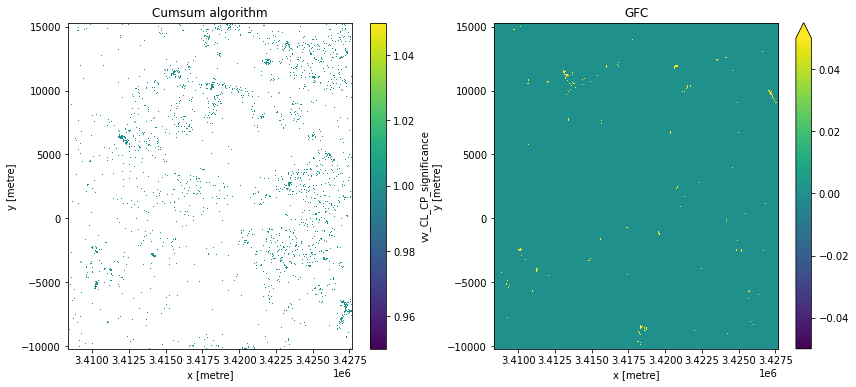

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
change_detected['vv_CL_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[0])
validation.plot.imshow(cmap="viridis", robust=True, ax=ax[1])
ax[0].set_title("Cumsum algorithm")
ax[1].set_title("GFC")
plt.show()

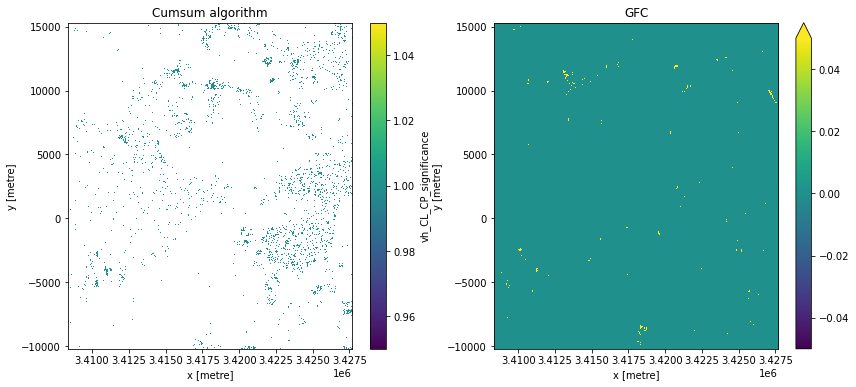

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
change_detected['vh_CL_CP_significance'].plot.imshow(cmap="viridis", robust=True, ax=ax[0])
validation.plot.imshow(cmap="viridis", robust=True, ax=ax[1])
ax[0].set_title("Cumsum algorithm")
ax[1].set_title("GFC")
plt.show()

The accuracy does not look good when comparing the results of the cumulative sum algorithm to the Global Forest Change dataset.